In [3]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
import illustris_python as il

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [5]:
def get_median_escape(df, edges, mass_type):
    medians = []
    error = []
    for i in range(len(edges)-1):
        sub_df = df[(edges[i]*(1-1e-10)<df[mass_type]) & (df[mass_type]<edges[i+1])]
        sub_esc = sub_df['Q0']*sub_df['f_esc']
        medians.append(sub_esc.median())
        error.append(sub_esc.std()/np.sqrt(len(sub_esc)))
    return np.array(medians), np.array(error)

def get_tng_masses(mass_type, snap):
    basePath = '/virgo/simulations/IllustrisTNG/L35n2160TNG/output'
    h = 0.6774
    if mass_type == 'StarMass':
        mass_norm = 1e4
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMassType')[:,4]/h*mass_norm
    elif mass_type == 'HaloMass':
        masses = il.groupcat.loadHalos(basePath,snap,fields='GroupMass')/h
    else:
        raise ValueError(f'"mass_type" has to be "StarMass" or "GroupMass" received {mass_type} instead')
    return masses

def get_esc_dens(df, redshift, bins=50, mass_type='StarMass'):
    redshift_map = {6:13, 8:8, 10:4}
    box_size=35.
    tng_masses = get_tng_masses(mass_type, snap=redshift_map[redshift])
    
    mass_min = tng_masses[tng_masses!=0].min()
    mass_max = tng_masses.max()
    edges = np.logspace(np.log10(mass_min),np.log10(mass_max), bins)
    
    centroids = []
    widths = []
    for i in range(len(edges)-1):
        centroids.append(edges[i]/2+edges[i+1]/2)
        widths.append(edges[i+1]-edges[i])
    centroids = np.array(centroids)
    widths = np.array(widths)
    hist, _ = np.histogram(tng_masses, bins=edges)
    hist_norm = hist/box_size**3
    
    median_esc, esc_err = get_median_escape(df[df.z==redshift], edges, mass_type)
    dens_esc = median_esc*hist_norm
    dens_err = esc_err*hist_norm
    
    hist_used = hist_norm[np.logical_not(np.isnan(median_esc))]
    centroids_used = centroids[np.logical_not(np.isnan(median_esc))]
    widths_used = widths[np.logical_not(np.isnan(median_esc))]
    
    used = [centroids_used, hist_used, widths_used]
    all_hist = [centroids, hist_norm, widths]
    uv_escape = [centroids, dens_esc, dens_err]
    return used, all_hist, uv_escape

In [138]:
def plot_esc_dens(df, redshift=6, bins=50, mass_type='StarMass', save=False):
    used, all_hist, uv_escape = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
    if mass_type == 'StarMass':
        mult = 1e6
        x_label = '$\log(M_\mathrm{star})[M_\mathrm{sun}]$'
    elif mass_type == 'HaloMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{halo})[M_\mathrm{sun}]$'
        
    fig, ax1 = plt.subplots()
    fig.suptitle(f'z={redshift}', fontsize=30)

    x_used = np.log10(np.array(used[0])*mult)
    x_all = np.log10(np.array(all_hist[0])*mult)
    width = x_used[1]-x_used[0]
    ax1.bar(x_all, all_hist[1], width=width, label='all halos')#, width=np.log10(np.array(all_hist[2])*mult))
    ax1.bar(x_used, used[1], width=width, label='halos used in simulations')#, width=np.log10(np.array(used[2])*mult))
    ax1.tick_params(length=10, width=3)
    ax1.tick_params(length=5, width=2, which='minor')
    ax1.set_yscale('log')
    ax1.set_ylabel('$n_\mathrm{clusters}[\mathrm{cMpc}^{-3}]$', size=45)
    ax1.set_xlabel(x_label, size=45)
    ax1.set_xlim(5.0,9.5)
    ax1.legend(fontsize=35)
    plt.rc('axes', linewidth=2)
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.rcParams["figure.figsize"] = (15,15)
    
    if save:
        path = f'/u/ivkos/analysis/plots/halo_density_z{redshift}.pdf'
        plt.savefig(path)
    
#     ax2 = ax1.twinx()
#     ax2.errorbar(uv_escape[0], uv_escape[1], yerr=uv_escape[2], linewidth=3, elinewidth=1, capsize=10, color='black')
#     ax2.tick_params(length=10, width=3)
#     ax2.tick_params(length=5, width=2, which='minor')
#     ax2.set_yscale('log')
#     ax2.set_ylabel('$N_\gamma[s^{-1}\mathrm{cMpc}^{-3}]$', size=30);
    return

In [132]:
def plot_z_esc(df, redshifts=[6,8,10], bins=50, mass_type='StarMass', save=False):
    fig, ax1 = plt.subplots()
    if mass_type == 'StarMass':
        mult = 1e6
        x_label = '$\log(M_\mathrm{star})[M_\mathrm{sun}]$'
    elif mass_type == 'HaloMass':
        mult = 1e10
        x_label = '$\log(M_\mathrm{halo})[M_\mathrm{sun}]$'
    
    for redshift in redshifts:
        _, _, uv_esc = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
        err_uv = np.array(uv_esc[2])/(np.log(10)*np.array(uv_esc[1]))
        escaped_uv = np.log10(np.array(uv_esc[1]))
        ax1.errorbar(np.log10(np.array(uv_esc[0])*mult), escaped_uv, yerr=err_uv, linewidth=3, elinewidth=1, capsize=10, label=f'z={redshift}')
        
    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=35) 
    plt.rc('ytick', labelsize=35) 
    plt.tick_params(length=10, width=3)
    plt.tick_params(length=5, width=2, which='minor')
    
    ax1.set_ylim(46, 51)
    ax1.set_ylabel(r'$\log(\dot{N}_\mathrm{ion})[s^{-1}\mathrm{cMpc}^{-3}]$', size=45)
    ax1.set_xlabel(x_label, size=45)
    ax1.legend(fontsize=35)
    if save:
        path = f'/u/ivkos/analysis/plots/uv_StarMass.pdf'
        plt.savefig(path)

In [61]:
def plot_uv_redshift(df, redshifts=[6,8,10], bins=50, mass_type='StarMass',log=False, save=False):
    tot_uv = []
    tot_uv_err = []
        
    for redshift in redshifts:
        _, _, uv_esc = get_esc_dens(df, redshift=redshift, bins=bins, mass_type=mass_type)
        tot_uv.append(np.sum(uv_esc[1][~np.isnan(uv_esc[1])]))
        err_not_nan = uv_esc[2][~np.isnan(uv_esc[2])]
        uv_err = np.sqrt(np.sum(np.square(np.array(err_not_nan))))
        tot_uv_err.append(uv_err)
        
    if log:
        y_label = r'$\log(\dot{N}_\mathrm{ion})[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'
        uv_err = np.array(uv_err)/(np.log(10)*np.array(tot_uv))
        tot_uv = np.log10(np.array(tot_uv))
    else:
        y_label = r'$\dot{N}_\mathrm{ion}[\mathrm{s}^{-1}\mathrm{cMpc}^{-3}]}$'

    plt.errorbar(redshifts, tot_uv, yerr=uv_err, marker='s', linewidth=3, elinewidth=1, capsize=10, markersize=25, linestyle='--')
    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=35) 
    plt.rc('ytick', labelsize=35) 
    plt.tick_params(length=10, width=3)
    plt.tick_params(length=5, width=2, which='minor')
    
    plt.xlabel('z', size=45)
    plt.ylabel(y_label, size=45)
    if save:
        path = f'/u/ivkos/analysis/plots/uv_z.pdf'
        plt.savefig(path)

In [143]:
def plot_scatter_color(df, y_prop='Q0', y_label=None, save = False):

    redshifts = [6,8,10]
    for redshift in redshifts:
        sub_df = df[df.z==redshift]
        x_values = np.log10(np.array(sub_df['StarMass'])*1e6)
        y_values = np.log10(np.array(sub_df[y_prop]))
        plt.scatter(x_values, y_values, label=f'z={redshift}')
    
    x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    if y_label == None:
        y_label = y_prop
    else:
        y_label = y_label
            
    
    plt.xlabel(x_label, size=35)
    plt.ylabel(y_label, size=35)
    plt.tick_params(length=16, width=4)
    plt.tick_params(length=8, width=3, which='minor')
    plt.legend(fontsize=35)

    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    plt.rcParams["figure.figsize"] = (20,20)
    
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/all_data_scatter.pdf')
    plt.show();
    return

In [8]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    return

In [9]:
df_no_dust = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
update_df(df_no_dust)

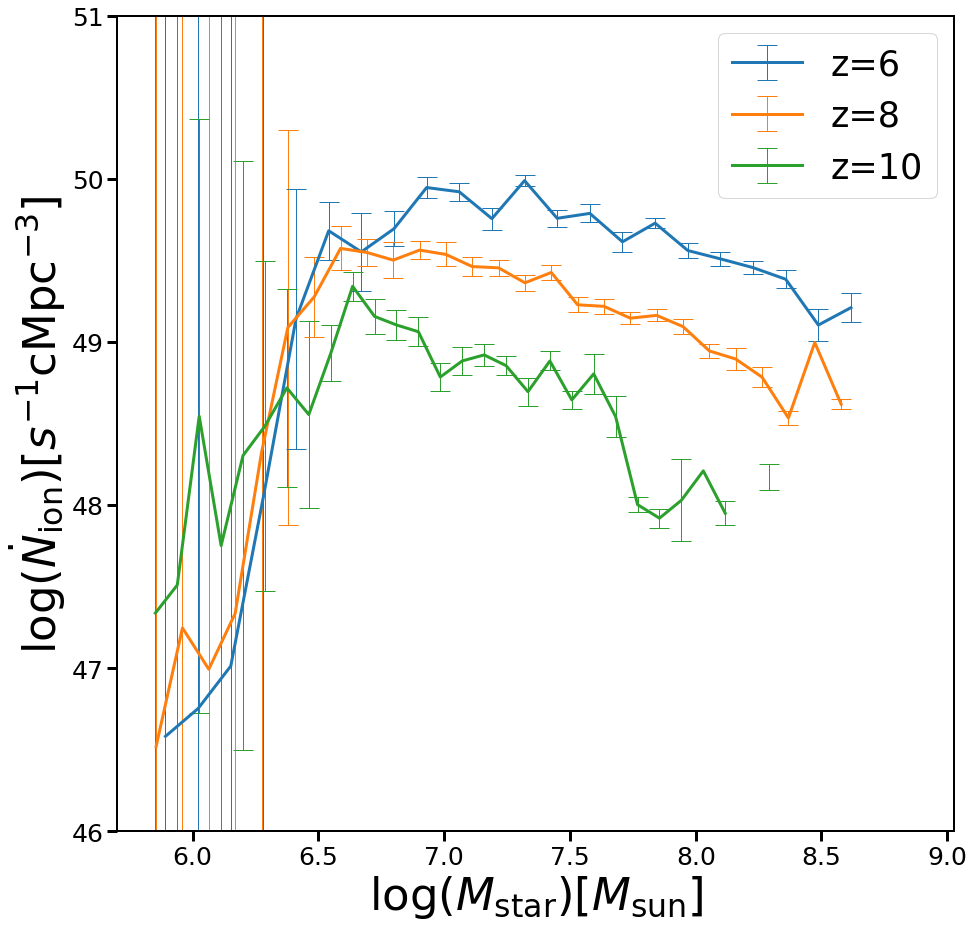

In [136]:
plot_z_esc(df_no_dust,save=True)

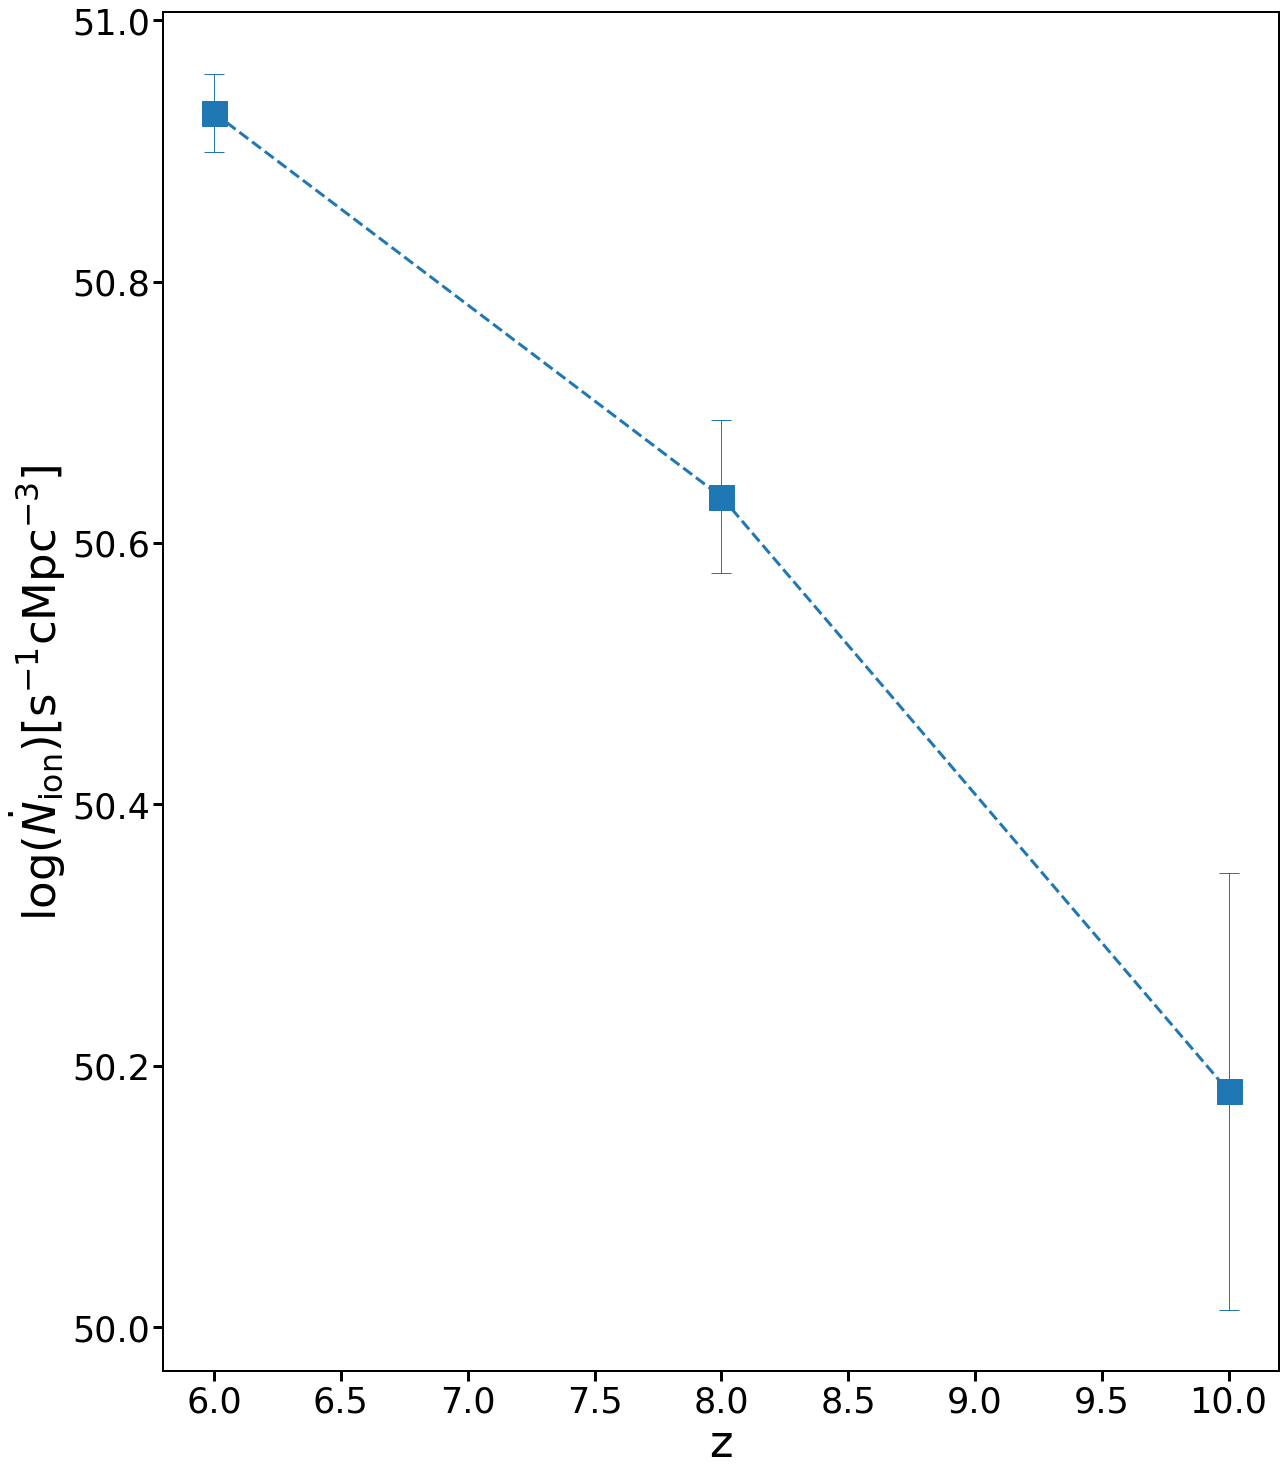

In [137]:
plot_uv_redshift(df_no_dust, redshifts=[6,8,10], bins=50, mass_type='StarMass', log=True, save=True)

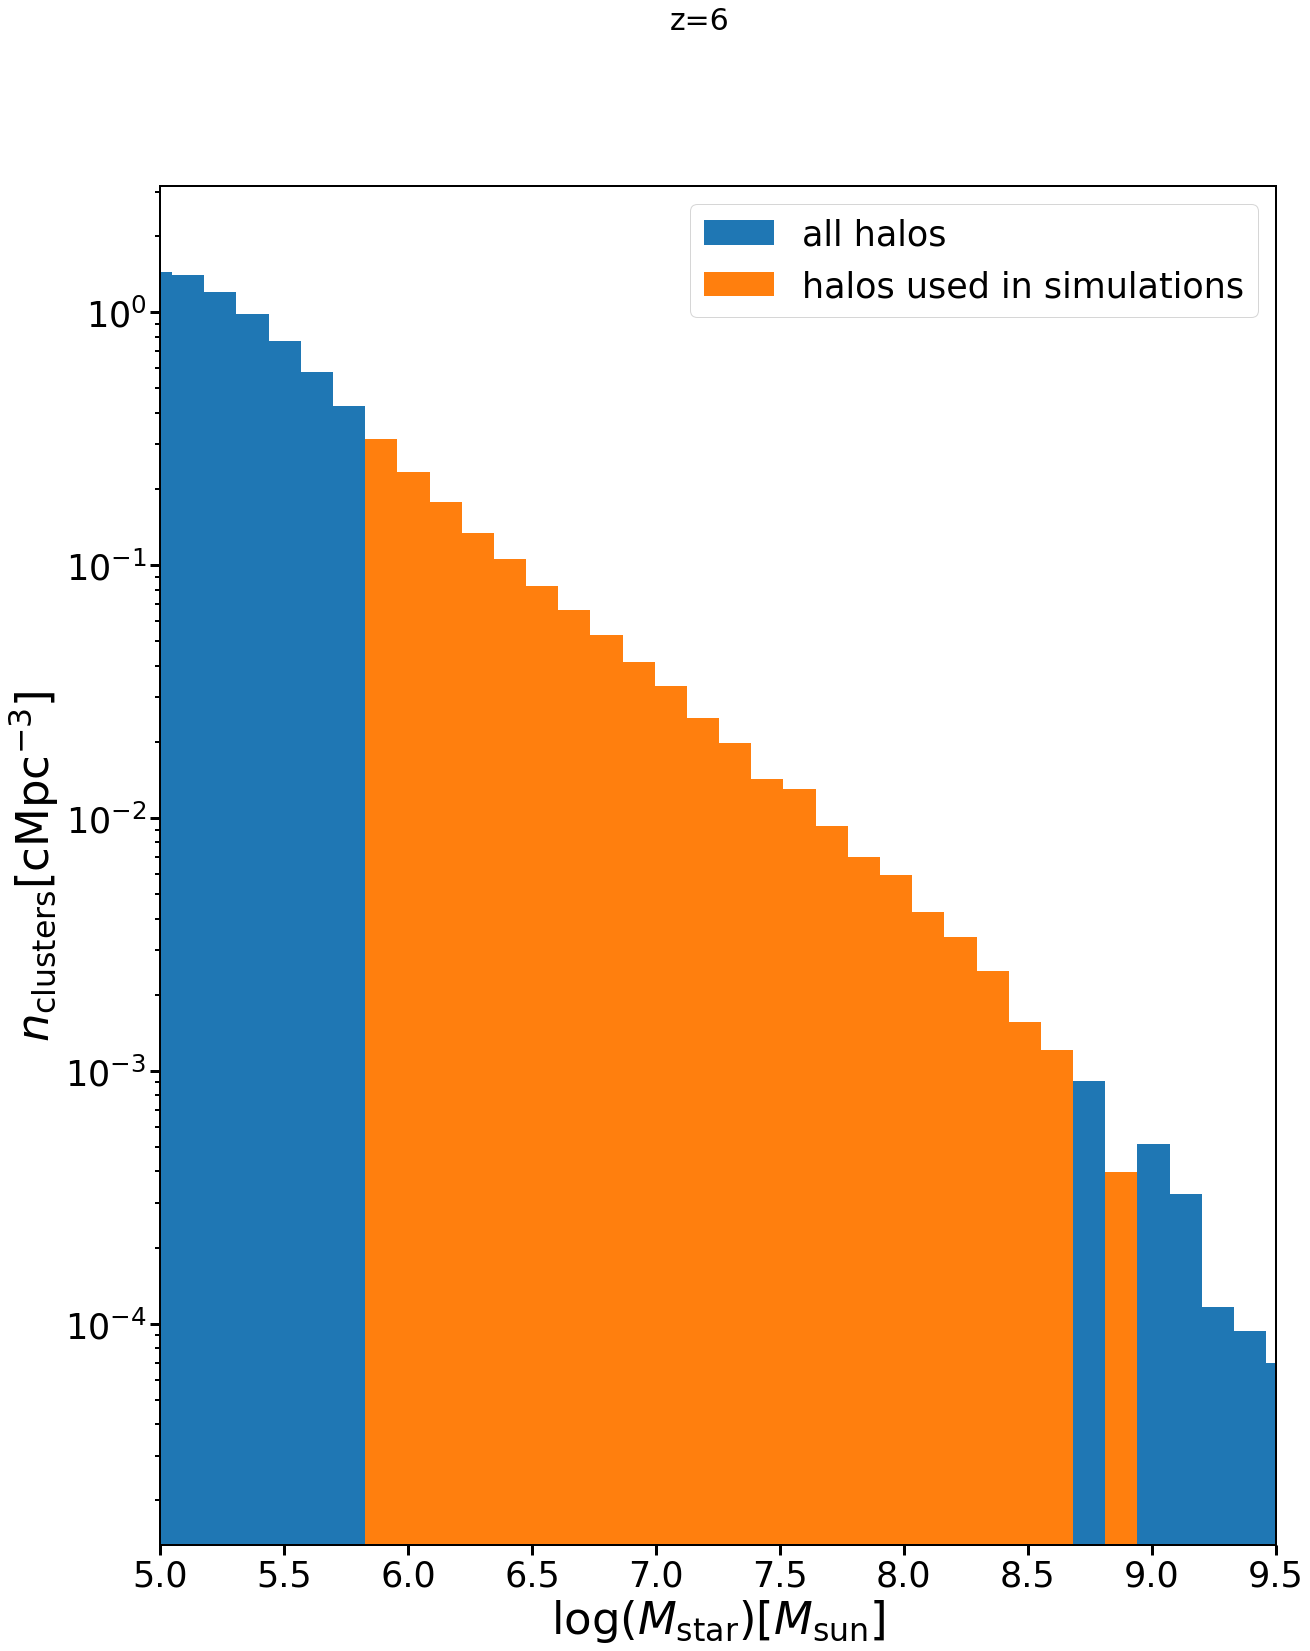

In [139]:
plot_esc_dens(df_no_dust, redshift=6, save=True)

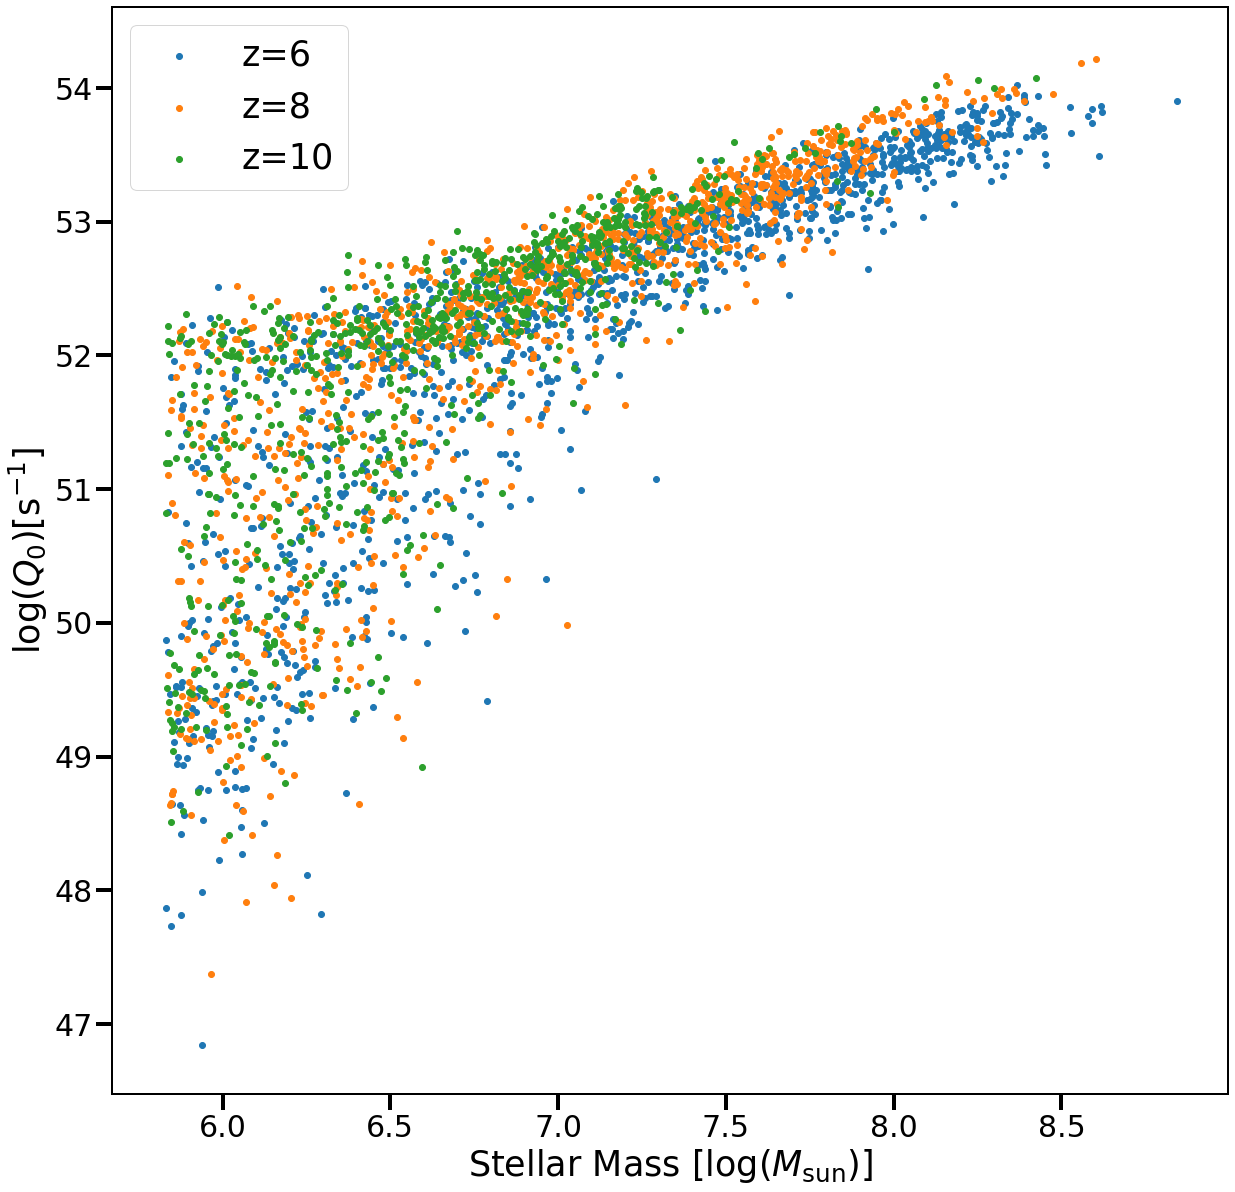

In [151]:
label = r'$\log(Q_0)[\mathrm{s}^{-1}]$'
plot_scatter_color(df_no_dust, y_prop='Q0', y_label=label, save = True)

In [157]:
np.array(df_no_dust[df_no_dust.f_esc<1e-3][['ID','z']])

array([[21316,     6],
       [13393,     6],
       [42719,     6],
       [22060,     6],
       [28243,     6],
       [43068,     6],
       [24455,     6],
       [14152,     6],
       [35500,     6],
       [34890,     6],
       [48801,     6],
       [33802,     6],
       [22409,     6],
       [31174,     6],
       [41348,     6],
       [35636,     6],
       [47783,     6],
       [10922,     6],
       [ 8245,     6],
       [33715,     6],
       [56612,     6],
       [39161,     6],
       [21389,     6],
       [43473,     6],
       [33848,     6],
       [17277,     6],
       [26313,     6],
       [19535,     6],
       [47519,     6],
       [66472,     6],
       [48293,     6],
       [35919,     6],
       [40126,     6],
       [16194,     6],
       [12064,     6],
       [17831,     6],
       [10762,     6],
       [11207,     6],
       [27226,     6],
       [24185,     6],
       [24058,     6],
       [36244,     6],
       [30718,     6],
       [234

In [ ]:
np.array(df_no_dust[df_no_dust.f_esc<1e-3].ID)